# Tipping Module Calibration
---
**Author** : Amaury Laridon

**Date** : 28/10/23

---

## Algorithme I with parameterization choice A for the fresh water flux

Here, we will numerically translate Algorithm I, which corresponds to the method described in [[Note de Travail - Cadre mathématique coefficients de couplage]] and which is a generalized application of Monteiro's (2022) method. We first look at the simplest choice of parameterization, i.e. choice "A" for the freshwater flow with a single forcing parameter.

### AMOC's calibration

#### Reminder of the mathematical framework
We wish to calibrate the following ODE
$$   \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1 T + e_{12} F_{GIS})\mu_\Psi(\Psi) = f(\Psi, T, F_{GIS})
\quad (9)   $$
The mathematical framework described in [[Note de Travail - Cadre mathématique coefficients de couplage]] has given us the following results for coefficient values,

$$a_1 = \frac{3(\Psi^{-}+\Psi^{+})}{2} \quad (1) $$
$$b_1 =  -3 \Psi^{-}\Psi^+ \quad (2)$$
$$  c_1^A  = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)} \quad (3) $$
$$  d_1 = -\frac{(\Psi^{+}-\Psi^{-})^3}{2(T^{+}_\Psi-T^{-}_\Psi)} \quad (4)   $$
$$ c_1^B  = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} \quad (5) $$
$$  e_{12} =-\frac{(\Psi^{+}-\Psi^{-})^3}{2(F_{GIS}^{+}-F_{GIS}^{-})} \quad (6) $$
$$ c_1 = c_1^A - e_{12}F_{GIS}^A \quad (7) $$
$$c_1 = c_1^B - d_1T_{\Psi}^B \quad (8) $$

For the experience noted A which represents the sensibility experiment with regard to temperature anomaly and a fixed fresh water flux we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^A + d_1 T)\mu_\Psi(\Psi) = f_{ExpA}(\Psi, T) \quad (10)  $$

For the experience noted B which represents the sensibility experiment with regard to fresh water flux and a fixed temperature anomaly we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^B + e_{12} F_{GIS})\mu_\Psi(\Psi) = f_{ExpB}(\Psi, F_{GIS})  \quad (11)  $$ 

#### Numerical implementation

First, we want to make a numerical implementation of this mathematical framework and test it by giving as input any critical values of the bifurcation coordinates. In other words, we're first going to see whether, given the data we want to reproduce, the algorithm is a good fit before, in a second phase, providing the algorithm with real experimental values as input.


##### Libraries import 

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import fsolve

##### Calibration module 

The critical values of the system variable under study (AMOC or GIS) are generally denoted by $xp, xm$, corresponding to the upper and lower critical values respectively. The critical values of the forcings are noted $op, om$. 

To avoid confusion, I explicitly define a function by coefficients, although the form is the same for many coefficients and I can simply change the arguments of the common function when calling the function and assigning it to the coefficient.

In [17]:
### Definition of the functions computing the coefficient's values. 
def a1(xp,xm):
    """Definition of the a_1 coefficient cfr. Eq.(1)"""
    return (3/2)*(xp+xm)
def b1(xp,xm):
    """Definition of the b_1 coefficient cfr. Eq.(2)"""
    return -3*xp*xm
def c1_A(xp,xm,op,om):
    """Definition of the c_1^A coefficient cfr. Eq.(3)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def d1(xp,xm,op,om):
    """Definition of the d_1 coefficient cfr. Eq.(4)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_B(xp,xm,op,om):
    """Definition of the c_1^B coefficient cfr. Eq.(5)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def e12(xp,xm,op,om):
    """Definition of the c_12 coefficient cfr. Eq.(6)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_from_A(c1_A, e12, F_A):
    """Definition of the c_1 coefficient from experience A cfr. Eq.(7)"""
    return c1_A-(e12*F_A)
def c1_from_B(c1_B, e12, T_B):
    """Definition of the c_1 coefficient from experience B cfr. Eq.(8)"""
    return c1_B-(e12*T_B)
### Definition of the calibration module ###
def calib_module_AMOC_ParamA(Psip,Psim, Tp, Tm, Fp, Fm, F_A, T_B):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux."""
    a_1 = a1(Psip, Psim)
    b_1 = b1(Psip,Psim)
    c1A = c1_A(Psip, Psim, Tp, Tm)
    d_1 = d1(Psip,Psim, Tp, Tm)
    c1B = c1_B(Psip, Psim, Fp, Fm)
    e_12 = e12(Psip, Psim, Fp, Fm)
    c1_f_A = c1_from_A(c1A, e_12, F_A)
    c1_f_B = c1_from_B(c1B, d_1, T_B)
    return [a_1, b_1, c1A, d_1, c1B, e_12, c1_f_A, c1_f_B]


##### Test data

In [18]:
### Sensibility Experiment parameters ###

F_A = 0.05 # Constant value of the fresh water flux for the sensibility experiment A [Sv] 
T_B = 2 # Constant value of the temperature for the sensibility experiment B [°C]
T_max = 10 # Maximum value of the temperature forcing for the sensibility experiment A [°C]
T_min = 0 # Minimal value of the temperature forcing for the sensibility experiment A [°C]
dT = 0.0005 # Infinitesimal value for the temperature forcing in the sensibility experiment A [°C] 
F_max = 1 # Maximum value of the fresh water flux forcing for the sensibility experiment B [Sv]
F_min = 0 # Minimum value of the fresh water flux forcing for the sensibility experiment B [Sv]
dF = 0.0005 # Infinitesimal value for the fresh water flux forcing in the sensibility experiment B [Sv] 

### Example of critical bifurcations value ### 
Psip = 1 # Lower critical value of the AMOC intensity 
Psim = 0.1 # Higher critical value of the AMOC intensity
Tp = 3 # Higher critical temperature forcing value for the AMOC 
Tm = 0.5 # Lower critical temperature forcing value for the AMOC 
Fp = 0.5 # Higher critical fresh water forcing value for the AMOC 
Fm = 0.05 # Lower critical fresh water forcing value for the AMOC 
taup = 100 # Timescale associated to the AMOC when it is on its ON state
taum = 200 # Timescale associated to the AMOC when it is on its OFF state

AMOC_params = [Psip, Psim, Tp, Tm, Fp, Fm, taup, taum] # List containing all the AMOC's parameters 

##### Algorithm's test

In [19]:
### Calibrated emulations ###

calibrate_coef = calib_module_AMOC_ParamA(Psip, Psim, Tp, Tm, Fp, Fm, F_A, T_B)

used_calib_coef_ExpA = [calibrate_coef[0], calibrate_coef[1], calibrate_coef[2], calibrate_coef[3]]
used_calib_coef_ExpB = [calibrate_coef[0], calibrate_coef[1], calibrate_coef[4], calibrate_coef[3]]



def dPsi_dt(Psi, T_forcing, F_forcing, model_parameters):
    """Definition of the Eq.(9)"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    calibrate_coef = calib_module_AMOC_ParamA(Psip, Psim, Tp, Tm, Fp, Fm, F_A, T_B)
    a = calibrate_coef[0]
    b = calibrate_coef[1]
    c = calibrate_coef[6]
    d = calibrate_coef[3]
    e = calibrate_coef[5]

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/taup
        else:
            return 1/taum

    return mu_psi(Psi)*(-Psi**3 + a*Psi**2 + b*Psi + c + d*T_forcing + e*F_forcing)

def f_ExpA(Psi, T_forcing):
    """Definition of the Eq.(10)"""
    return -Psi**3+used_calib_coef_ExpA[0]*Psi**2+used_calib_coef_ExpA[1]*Psi+used_calib_coef_ExpA[2]+used_calib_coef_ExpA[3]*T_forcing
def f_ExpB(Psi, F_forcing):
    """Definition of the Eq.(11)"""
    return -Psi**3+used_calib_coef_ExpB[0]*Psi**2+used_calib_coef_ExpB[1]*Psi+used_calib_coef_ExpB[2]+used_calib_coef_ExpA[3]*F_forcing

### Analytical data ###



##### Phase Portrait 

Phase portrait of the $\frac{d\Psi}{dt} = f(\Psi)$ function, Eq.(9) and computation of the equilibrium points

[array([-0.25784889]), array([0.61036203]), array([1.29748686])]


[]

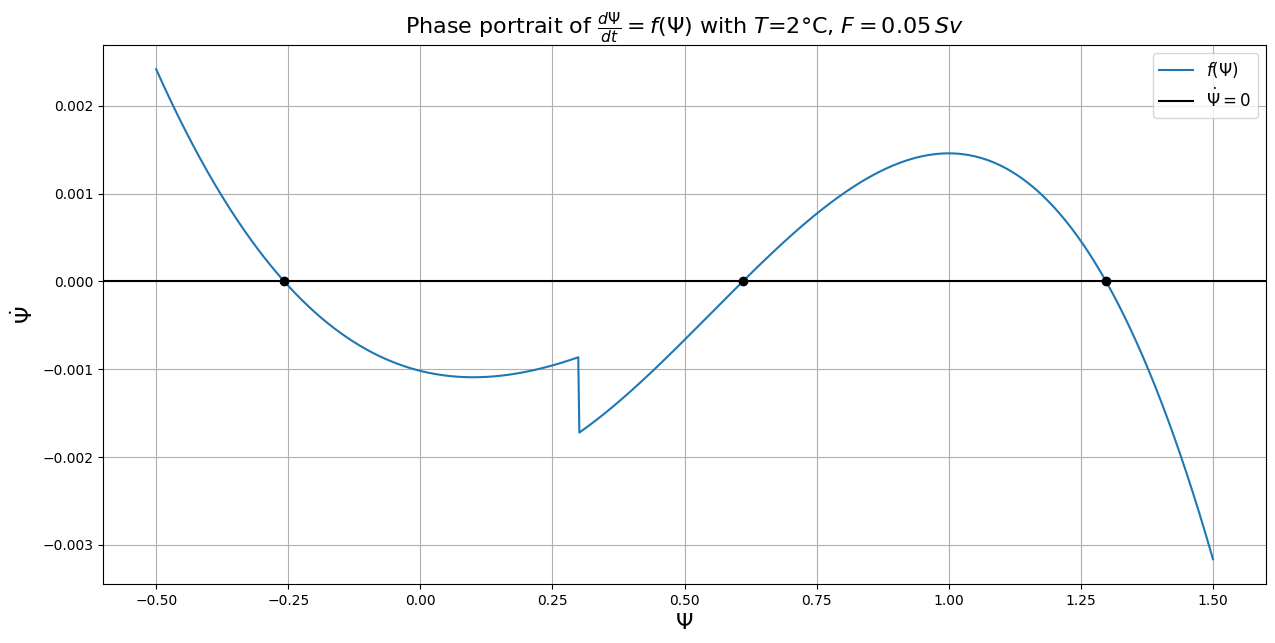

In [28]:
### Computation of the equilibirum points of equation (9) ####

eq_points_1 = fsolve(dPsi_dt, 0, args=(T_B, F_A, AMOC_params))
eq_points_2 = fsolve(dPsi_dt, 0.5, args=(T_B, F_A, AMOC_params))
eq_points_3 = fsolve(dPsi_dt, 1.25, args=(T_B, F_A, AMOC_params))

eq_points = [eq_points_1, eq_points_2, eq_points_3]
print(eq_points)

### Plot of the phase portrait Eq.(9) with equilibrium points
N = 1000
Psi = np.linspace(-0.5, 1.5, N)
Y = np.zeros(N)
for i in range(N):
    y = dPsi_dt(Psi[i], T_B, F_A, AMOC_params)
    Y[i] = y
    
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.plot(Psi, Y, label = r"$f(\Psi)$")
plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")
for i in range(3):
    plt.plot(eq_points[i], dPsi_dt(eq_points[i], T_B, F_A, AMOC_params), "ko")
ax.set_xlabel(r"$\Psi$", fontsize = 16)
ax.set_ylabel(r"$\dot{\Psi}$", fontsize = 16)
ax.set_title("Phase portrait of "+r"$\frac{d\Psi}{dt} = f(\Psi)$"+" with "+r"$T$={}°C,".format(T_B)+r" $F={}\,Sv$".format(F_A), fontsize = 16)
ax.legend(fontsize = 12)
plt.grid()
plt.plot()

# ### Plot of the phase portrait Eq.(10) 
# Y_ExpA = f_ExpA(Psi, T_forcing_val)

# fig, ax = plt.subplots(1,1,figsize=(15,7))

# ax.plot(Psi, Y_ExpA, label = r"$f_{ExpA}(\Psi)$", color="g")
# plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")
# ax.set_xlabel(r"$\Psi$", fontsize = 16)
# ax.set_ylabel(r"$\dot{\Psi}$", fontsize = 16)
# ax.set_title("Phase portrait of "+r"$\frac{d\Psi}{dt} = f_{ExpA}(\Psi)$"+" with "+r"$T$={}°C,".format(T_forcing_val)+r" $F={}\,Sv$".format(F_forcing_val), fontsize = 16)
# ax.legend(fontsize = 12)
# plt.grid()
# plt.plot()

# ### Plot of the phase portrait Eq.(11)
# Y_ExpB = f_ExpB(Psi, F_forcing_val)

# fig, ax = plt.subplots(1,1,figsize=(15,7))

# ax.plot(Psi, Y, label = r"$f_{ExpB}(\Psi)$", color="r")
# plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")
# ax.set_xlabel(r"$\Psi$", fontsize = 16)
# ax.set_ylabel(r"$\dot{\Psi}$", fontsize = 16)
# ax.set_title("Phase portrait of "+r"$\frac{d\Psi}{dt} = f_{ExpB}(\Psi)$"+" with "+r"$T$={}°C,".format(T_forcing_val)+r" $F={}\,Sv$".format(F_forcing_val), fontsize = 16)
# ax.legend(fontsize = 12)
# plt.grid()
# plt.plot()


##### Steady States for fixed $F_{GIS}^A$ and $T_\Psi^B$

In [ ]:
# Looks for steady states with 0 < Psi < 1 for fixed T_forcing and F_forcing
def psi_roots(T_forcing, F_forcing, AMOC_parameters):
    def g(Psi):
        y = dPsi_dt(Psi, T_forcing, F_forcing, AMOC_parameters)
        return y
    roots = fsolve(g, 0)
    return roots 

##### Steady States for fixed $F_{GIS}^A$

In [ ]:
def steady_data_ExpA(AMOC_parameters):
    #computing the steady states
    roots = [[T_forcing, psi_roots(T_forcing,F_forcing=F_A, AMOC_parameters=AMOC_parameters)] for T_forcing in np.arange(T_min,T_max, dT)]
    Tf_roots = [ [Tf_roots[0], root] for Tf_roots in roots for root in Tf_roots[1]]
    Tf_list = [elem[0] for elem in Tf_roots]
    roots_list = [elem[1] for elem in Tf_roots];
    return Tf_list, roots_list

##### Steady States for fixed $T_\Psi^B$

In [ ]:
def steady_data_ExpB(AMOC_parameters):
    #computing the steady states
    roots = [[F_forcing, psi_roots(F_forcing,T_forcing=T_B, AMOC_parameters=AMOC_parameters)] for F_forcing in np.arange(F_min, F_max, d0)]
    F_roots = [ [F_roots[0], root] for F_roots in roots for root in F_roots[1]]
    F_list = [elem[0] for elem in Tf_roots]
    roots_list = [elem[1] for elem in Tf_roots];
    return F_list, roots_list

##### Computation of the steady states and organisation

In [ ]:
# Computation of the steady states
Tf_list_static, roots_list = steady_data_ExpA(AMOC_params)
# Organisation of the steady states 
index = 0 

unstable_roots = []
unstable_temps = []

upper_roots = []
upper_temps = []

lower_roots = []
lower_temps = []

for root in roots_list:
    
    if max(0,AMOC_params[1]) <= root <= AMOC_params[0]:
        unstable_roots.append(root)
        unstable_temps.append(Tf_list_static[index])
        index +=1  
    if root >= AMOC_params[0]:
        upper_roots.append(root)
        upper_temps.append(Tf_list_static[index])
        index +=1 
    if root <= max(0,AMOC_params[1]):
        lower_roots.append(root)
        lower_temps.append(Tf_list_static[index])
        index +=1 

"""
unstable = max(0,AMOC_params[1]) .< roots_list .<= AMOC_params[0]
unstable_temps = Tf_list_static[unstable]
unstable_vols = roots_list[unstable]

upper = roots_list .>= AMOC_params[0]
upper_temps = Tf_list_static[upper]
upper_vols = roots_list[upper]

lower = roots_list .<= max(0,AMOC_params[1])
lower_temps = Tf_list_static[lower]
lower_vols = roots_list[lower]
"""


'\nunstable = max(0,AMOC_params[1]) .< roots_list .<= AMOC_params[0]\nunstable_temps = Tf_list_static[unstable]\nunstable_vols = roots_list[unstable]\n\nupper = roots_list .>= AMOC_params[0]\nupper_temps = Tf_list_static[upper]\nupper_vols = roots_list[upper]\n\nlower = roots_list .<= max(0,AMOC_params[1])\nlower_temps = Tf_list_static[lower]\nlower_vols = roots_list[lower]\n'

##### Plotting the steady states

[]

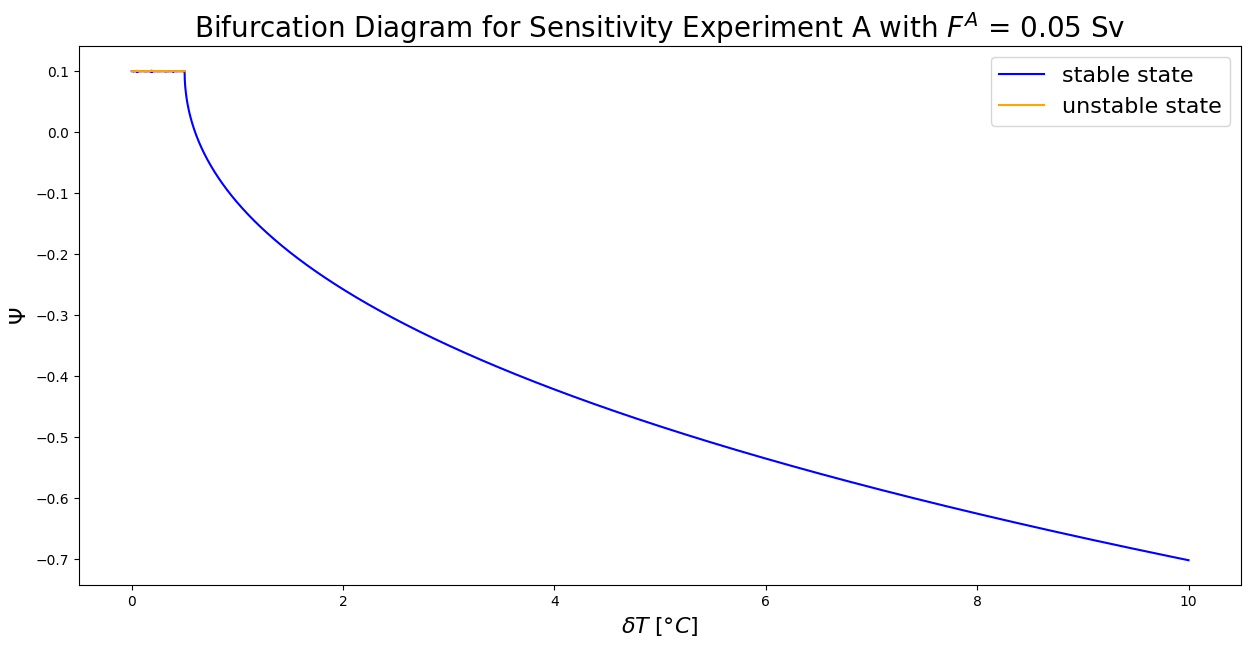

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.plot(upper_temps, upper_roots, color="blue", label="stable state")
ax.plot(lower_temps, lower_roots, color="blue")
ax.plot(unstable_temps, unstable_roots, color="orange", label="unstable state")
ax.set_ylabel(r"$\Psi$", fontsize=16)
ax.set_xlabel(r"$\delta T\;[°C]$", fontsize=16)
plt.title("Bifurcation Diagram for Sensitivity Experiment A with "+r"$F^A$ = {}".format(F_A)+" Sv", fontsize=20)
plt.legend(fontsize=16)
plt.plot()

In [ ]:
""" ### Bifurcation diagrams ###

fig, ax = plt.subplots(1,2,figsize=(15,7))

# AMOC Bifurcation diagram for temperature anomaly #
ax[0].plot(T_forcing, calib_psi_ExpA, label = "Calibrated ExpA", color="r")
ax[0].set_xlabel(r"$\delta T\; [°C]$", fontsize = 16)
ax[0].set_ylabel(r"$\Psi$", fontsize = 16)
ax[0].set_title(r"$\delta T$"+" Sensibility Experiment A", fontsize = 16)
ax[0].legend(fontsize = 12)

# AMOC Bifurcation diagram for fresh water flux anomaly #
ax[1].plot(F_forcing, calib_psi_ExpB, label = "Calibrated ExpB", color="g")
ax[1].set_xlabel(r"$F_{GIS}\;[Sv]$", fontsize = 16)
ax[1].set_ylabel(r"$\Psi$", fontsize = 16)
ax[1].set_title(r"$F_{GIS}$"+" Sensibility Experiment B", fontsize = 16)
ax[1].legend(fontsize = 14)

plt.suptitle("Bifurcation diagram : analytical against calibrated", fontsize = 20)
plt.plot() """

' ### Bifurcation diagrams ###\n\nfig, ax = plt.subplots(1,2,figsize=(15,7))\n\n# AMOC Bifurcation diagram for temperature anomaly #\nax[0].plot(T_forcing, calib_psi_ExpA, label = "Calibrated ExpA", color="r")\nax[0].set_xlabel(r"$\\delta T\\; [°C]$", fontsize = 16)\nax[0].set_ylabel(r"$\\Psi$", fontsize = 16)\nax[0].set_title(r"$\\delta T$"+" Sensibility Experiment A", fontsize = 16)\nax[0].legend(fontsize = 12)\n\n# AMOC Bifurcation diagram for fresh water flux anomaly #\nax[1].plot(F_forcing, calib_psi_ExpB, label = "Calibrated ExpB", color="g")\nax[1].set_xlabel(r"$F_{GIS}\\;[Sv]$", fontsize = 16)\nax[1].set_ylabel(r"$\\Psi$", fontsize = 16)\nax[1].set_title(r"$F_{GIS}$"+" Sensibility Experiment B", fontsize = 16)\nax[1].legend(fontsize = 14)\n\nplt.suptitle("Bifurcation diagram : analytical against calibrated", fontsize = 20)\nplt.plot() '